# Image Segmentation of Femoral Cartalige Using Unets and Reinforcement Learning Optimization of Image Preprocessing

In this notebook, we address the task of segmenting femoral cartilage from MRI images of patients' knees. The dataset used in this project comes from the Musculoskeletal Imaging and Orthopaedic Biomechanics Laboratory, led by Dr. Nic Fiorentino at the University of Vermont. One of the areas of research in Dr. Fiorentino’s lab is the study of cartilage degradation following ACL reconstruction surgery. Historically, segmentation of knee cartilage in these images has been performed manually, a process that is both time-consuming and prone to human error. Our goal is to develop a tool that streamlines this workflow by providing initial image processing to reduce the manual effort required, while also exploring the application of machine learning in medical imaging.

Our first objective was to develop and train a U-Net model capable of automatically segmenting cartilage in the MRI images. Secondly, we explored the use of reinforcement learning to optimize image preprocessing steps, with the aim of improving the U-Net’s performance. Below, we present the code and brief explanations of how we approached and implemented these objectives with encouraging results.



# Imports and Google Drive Mount

In [2]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Final Project/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random

# Define Model and Train
Below are the classes used to define the model architechure and generate and preprocess the data set for the simple Unet application to the image set.

In [4]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

class CartilageDataset(Dataset):
    """
    Dataset class for MRI cartilage segmentation
    """
    def __init__(self, data_df, transform=None, target_type='femoral'):
        """
        Args:
            data_df (pandas.DataFrame): DataFrame containing paths and metadata
            transform (callable, optional): Optional transform to be applied on a sample
            target_type (str): Type of cartilage to segment ('femoral' or 'tibial')
        """
        self.data_df = data_df
        self.transform = transform
        self.target_type = target_type

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        # Get row from dataframe
        row = self.data_df.iloc[idx]

        # Load MRI data
        mri_file = row['mri_file']
        mri_data = loadmat(mri_file)
        v = mri_data['v']
        # mri_slice = np.squeeze(v[:,:,row['slice_idx'],0])  # First spin lock time

        # Take the middle 208 x 208 region
        mri_slice = np.squeeze(v[152:360,152:360,row['slice_idx'], 0])  # First spin lock time

        # Normalize MRI data to [0,1]
        mri_slice = (mri_slice - mri_slice.min()) / (mri_slice.max() - mri_slice.min())

        # Create mask (all zeros if no mask exists)
        mask = np.zeros((512, 512), dtype=np.float32)

        # Load mask if it exists
        if row['has_mask']:
            mask_file = row['mask_file']
            mask_data = loadmat(mask_file)

            # Get mask based on target type
            if self.target_type == 'femoral' and row['has_femoral']:
                maskf = mask_data['maskf']
                maskf_combined = np.squeeze(maskf[:,0,:] | maskf[:,1,:])

                # Find the index in rsl that corresponds to our slice
                rsl = mask_data['rsl'].flatten() - 1  # Convert to 0-based indexing
                slice_idx_in_rsl = np.where(rsl == row['slice_idx'])[0][0]

                # Reshape mask to image dimensions
                mask = np.reshape(maskf_combined[:, slice_idx_in_rsl], (512, 512)).T

            elif self.target_type == 'tibial' and row['has_tibial']:
                maskt = mask_data['maskt']
                maskt_combined = np.squeeze(maskt[:,0,:] | maskt[:,1,:])

                # Find the index in rsl that corresponds to our slice
                rsl = mask_data['rsl'].flatten() - 1  # Convert to 0-based indexing
                slice_idx_in_rsl = np.where(rsl == row['slice_idx'])[0][0]

                # Reshape mask to image dimensions
                mask = np.reshape(maskt_combined[:, slice_idx_in_rsl], (512, 512)).T

        # reduce mask to a 208x208 central region of the image
        mask = mask[152:360, 152:360]
        # Convert to torch tensors
        mri_slice = torch.from_numpy(mri_slice).float().unsqueeze(0)  # Add channel dimension
        mask = torch.from_numpy(mask).float().unsqueeze(0)  # Add channel dimension

        # Apply transforms if any
        if self.transform:
            mri_slice = self.transform(mri_slice)

        return {
            'image': mri_slice,
            'mask': mask,
            'patient_id': row['patient_id'],
            'side': row['side'],
            'slice_idx': row['slice_idx']
        }

The Unet class defines the architecture for the implemented Unet below is an image of the architecture.


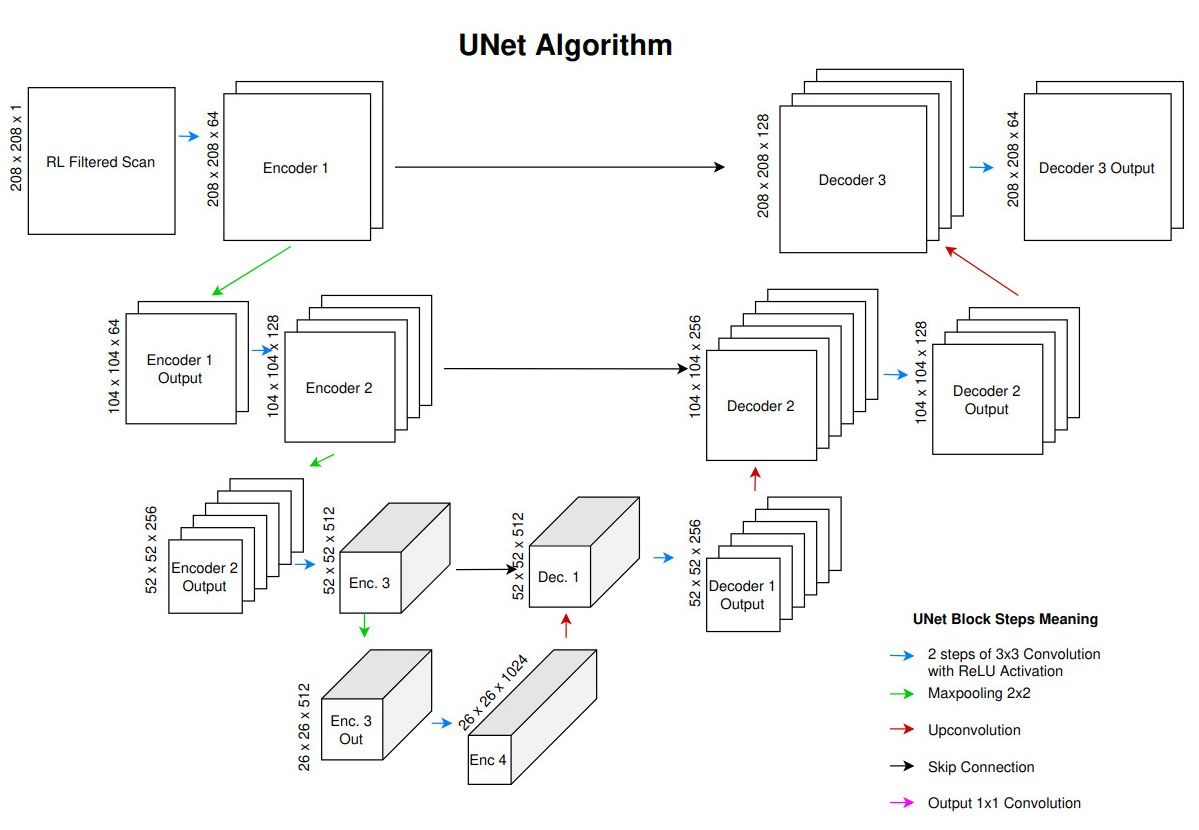

In [5]:
from IPython.display import Image
Image('/content/drive/MyDrive/Final Project/UNet-RL_hybrid_model.jpg')


In [6]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()

        # Encoder (downsampling)
        self.enc1 = self._encoder_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc2 = self._encoder_block(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc3 = self._encoder_block(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc4 = self._encoder_block(256, 512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = self._encoder_block(512, 1024)

        # Decoder (upsampling)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = self._decoder_block(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self._decoder_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self._decoder_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self._decoder_block(128, 64)

        # Final output layer
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def _encoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def _decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))
        enc4 = self.enc4(self.pool3(enc3))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool4(enc4))

        # Decoder with skip connections
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)

        # Final output
        output = self.final_conv(dec1)
        output = self.sigmoid(output)

        return output

This section of code prepares a .csv file containing the metadata on each image required by the lab.

In [7]:
def prepare_dataset():
    """
    Prepare dataset by creating a DataFrame with all slices and their metadata
    """
    data = []

    # Get all patient directories
    patient_dirs = sorted([d for d in os.listdir('.') if os.path.isdir(d) and d.isdigit()])

    for patient_id in tqdm(patient_dirs, desc="Processing patients"):
        # Process left knee (series 401)
        left_mri_file = os.path.join(patient_id, f'T1rho_S401.mat')
        left_mask_file = os.path.join(patient_id, f'T1rho_S401_prois.mat')

        if os.path.exists(left_mri_file) and os.path.exists(left_mask_file):
            # Load MRI data to get number of slices
            try:
                mri_data = loadmat(left_mri_file)
                v = mri_data['v']
                num_slices = v.shape[2]

                # Load mask data to get slices with masks
                mask_data = loadmat(left_mask_file)
                rsl = mask_data['rsl'].flatten() - 1  # Convert to 0-based indexing
                rslf = mask_data['rslf'].flatten() - 1 if 'rslf' in mask_data else np.array([])
                rslt = mask_data['rslt'].flatten() - 1 if 'rslt' in mask_data else np.array([])

                # Add all slices to dataset
                for slice_idx in range(num_slices):
                    has_mask = slice_idx in rsl
                    has_femoral = slice_idx in rslf
                    has_tibial = slice_idx in rslt

                    data.append({
                        'patient_id': patient_id,
                        'side': 'Left',
                        'mri_file': left_mri_file,
                        'mask_file': left_mask_file,
                        'slice_idx': slice_idx,
                        'has_mask': has_mask,
                        'has_femoral': has_femoral,
                        'has_tibial': has_tibial
                    })
            except Exception as e:
                print(f"Error processing {left_mri_file}: {e}")

        # Process right knee (series 1401)
        right_mri_file = os.path.join(patient_id, f'T1rho_S1401.mat')
        right_mask_file = os.path.join(patient_id, f'T1rho_S1401_prois.mat')

        if os.path.exists(right_mri_file) and os.path.exists(right_mask_file):
            # Load MRI data to get number of slices
            try:
                mri_data = loadmat(right_mri_file)
                v = mri_data['v']
                num_slices = v.shape[2]

                # Load mask data to get slices with masks
                mask_data = loadmat(right_mask_file)
                rsl = mask_data['rsl'].flatten() - 1  # Convert to 0-based indexing
                rslf = mask_data['rslf'].flatten() - 1 if 'rslf' in mask_data else np.array([])
                rslt = mask_data['rslt'].flatten() - 1 if 'rslt' in mask_data else np.array([])

                # Add all slices to dataset
                for slice_idx in range(num_slices):
                    has_mask = slice_idx in rsl
                    has_femoral = slice_idx in rslf
                    has_tibial = slice_idx in rslt

                    data.append({
                        'patient_id': patient_id,
                        'side': 'Right',
                        'mri_file': right_mri_file,
                        'mask_file': right_mask_file,
                        'slice_idx': slice_idx,
                        'has_mask': has_mask,
                        'has_femoral': has_femoral,
                        'has_tibial': has_tibial
                    })
            except Exception as e:
                print(f"Error processing {right_mri_file}: {e}")

    # Create DataFrame
    df = pd.DataFrame(data)

    # Save DataFrame to CSV
    df.to_csv('cartilage_dataset.csv', index=False)

    print(f"Dataset prepared with {len(df)} slices")
    print(f"Slices with femoral cartilage: {df['has_femoral'].sum()}")
    print(f"Slices with tibial cartilage: {df['has_tibial'].sum()}")

    return df

In [8]:
def dice_loss(pred, target):
    """
    Dice loss for segmentation
    """
    smooth = 1.0

    # Flatten predictions and targets
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)

    # Calculate intersection and union
    intersection = (pred_flat * target_flat).sum()
    union = pred_flat.sum() + target_flat.sum()

    # Calculate Dice coefficient
    dice = (2.0 * intersection + smooth) / (union + smooth)

    return 1.0 - dice

Below is code train the model with early stopping implemented. The best model is iteratively saved to the same directory as the notebook.

In [9]:
def train_model(model, train_loader, val_loader, device, num_epochs=50):
    """
    Train the model
    """
    # Define optimizer and scheduler
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    # Define loss function
    criterion = dice_loss

    # Training history
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    epochs_no_improve = 0
    patience = 3
    min_improvement = 0.001

    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            # Get data
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Calculate loss
            loss = criterion(outputs, masks)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Update running loss
            train_loss += loss.item() * images.size(0)

        # Calculate average training loss
        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                # Get data
                images = batch['image'].to(device)
                masks = batch['mask'].to(device)

                # Forward pass
                outputs = model(images)

                # Calculate loss
                loss = criterion(outputs, masks)

                # Update running loss
                val_loss += loss.item() * images.size(0)

        # Calculate average validation loss
        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)

        # Update learning rate
        scheduler.step(val_loss)

        # Print progress
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # implement early stopping
        if (best_val_loss - val_loss) > min_improvement:
            epochs_no_improve = 0  # Reset counter
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'best_model_{model.__class__.__name__}.pth')
            print(f"Saved best model with validation loss: {best_val_loss:.4f}")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig(f'training_history_{model.__class__.__name__}.png')
    plt.close()

    return model, train_losses, val_losses

In [10]:
def evaluate_model(model, test_loader, device):
    """
    Evaluate the model on the test set and plot samples
    """
    model.eval()
    dice_scores = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            # Get data
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)

            # Forward pass
            outputs = model(images)

            # Calculate Dice score
            dice = 1.0 - dice_loss(outputs, masks).item()
            dice_scores.append(dice)

            # Save some example predictions
            if len(dice_scores) <= 10:  # Save first 10 examples
                # Convert tensors to numpy arrays
                image = images[0, 0].cpu().numpy()
                mask = masks[0, 0].cpu().numpy()
                pred = outputs[0, 0].cpu().numpy()

                # Create figure
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))

                # Plot image
                axes[0].imshow(image, cmap='gray')
                axes[0].set_title('MRI Slice')
                axes[0].axis('off')

                # Plot ground truth mask
                axes[1].imshow(mask, cmap='Blues')
                axes[1].set_title('Ground Truth')
                axes[1].axis('off')

                # Plot prediction
                axes[2].imshow(pred, cmap='Reds')
                axes[2].set_title(f'Prediction (Dice: {dice:.4f})')
                axes[2].axis('off')

                # Save figure
                plt.tight_layout()
                plt.savefig(f'example_{len(dice_scores)}.png', bbox_inches='tight')
                plt.show()
                plt.close()

    # Calculate average Dice score
    avg_dice = np.mean(dice_scores)
    print(f"Average Dice score: {avg_dice:.4f}")

    return avg_dice, dice_scores

Preprocess and load data for training then configure datasets into pytorch tensors/Dataloaders for train, validation and test sets.

In [11]:

# Check if dataset CSV exists, otherwise create it
if os.path.exists('cartilage_dataset.csv'):
    print("Loading existing dataset...")
    df = pd.read_csv('cartilage_dataset.csv')
else:
    print("Preparing dataset...")
    df = prepare_dataset()

# Split dataset into train, validation, and test sets (70/20/10)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df[['has_femoral', 'has_tibial']])
val_df, test_df = train_test_split(temp_df, test_size=0.33, random_state=42, stratify=temp_df[['has_femoral', 'has_tibial']])

print(f"Train set: {len(train_df)} slices")
print(f"Validation set: {len(val_df)} slices")
print(f"Test set: {len(test_df)} slices")

# Create datasets for femoral cartilage
train_dataset_femoral = CartilageDataset(train_df, target_type='femoral')
val_dataset_femoral = CartilageDataset(val_df, target_type='femoral')
test_dataset_femoral = CartilageDataset(test_df, target_type='femoral')

# Create data loaders
batch_size = 32

train_loader_femoral = DataLoader(train_dataset_femoral, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader_femoral = DataLoader(val_dataset_femoral, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader_femoral = DataLoader(test_dataset_femoral, batch_size=1, shuffle=False, num_workers=4)



Loading existing dataset...
Train set: 1209 slices
Validation set: 347 slices
Test set: 172 slices


Train and evaluate the model.

In [ ]:
# Set device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create and train femoral cartilage model
print("\nTraining femoral cartilage model...")
femoral_model = UNet(in_channels=1, out_channels=1).to(device)
femoral_model, train_losses_femoral, val_losses_femoral = train_model(
    femoral_model, train_loader_femoral, val_loader_femoral, device
)

# Evaluate femoral cartilage model
print("\nEvaluating femoral cartilage model...")
femoral_model.load_state_dict(torch.load('best_model_UNet.pth'))
avg_dice_femoral, dice_scores_femoral = evaluate_model(femoral_model, test_loader_femoral, device)

# Print final results
print("\nFinal Results:")
print(f"Femoral Cartilage - Average Dice Score: {avg_dice_femoral:.4f}")

Using device: cuda

Training femoral cartilage model...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/50 - Validation: 100%|██████████| 11/11 [05:28<00:00, 29.84s/it]


Epoch 1/50 - Train Loss: 0.9400, Val Loss: 0.9468
Saved best model with validation loss: 0.9468


Epoch 2/50 - Validation: 100%|██████████| 11/11 [05:30<00:00, 30.07s/it]


Epoch 2/50 - Train Loss: 0.9187, Val Loss: 0.9178
Saved best model with validation loss: 0.9178


Epoch 3/50 - Validation: 100%|██████████| 11/11 [05:27<00:00, 29.74s/it]


Epoch 3/50 - Train Loss: 0.9120, Val Loss: 0.9132
Saved best model with validation loss: 0.9132


Epoch 4/50 - Validation: 100%|██████████| 11/11 [05:27<00:00, 29.81s/it]


Epoch 4/50 - Train Loss: 0.9064, Val Loss: 0.9077
Saved best model with validation loss: 0.9077


Epoch 5/50 - Validation: 100%|██████████| 11/11 [05:25<00:00, 29.63s/it]


Epoch 5/50 - Train Loss: 0.9007, Val Loss: 0.9021
Saved best model with validation loss: 0.9021


Epoch 6/50 - Validation: 100%|██████████| 11/11 [05:27<00:00, 29.73s/it]


Epoch 6/50 - Train Loss: 0.8943, Val Loss: 0.8947
Saved best model with validation loss: 0.8947


Epoch 7/50 - Validation: 100%|██████████| 11/11 [05:27<00:00, 29.78s/it]


Epoch 7/50 - Train Loss: 0.8874, Val Loss: 0.8872
Saved best model with validation loss: 0.8872


Epoch 8/50 - Validation: 100%|██████████| 11/11 [05:26<00:00, 29.67s/it]


Epoch 8/50 - Train Loss: 0.8796, Val Loss: 0.8808
Saved best model with validation loss: 0.8808


Epoch 9/50 - Validation: 100%|██████████| 11/11 [05:26<00:00, 29.72s/it]


Epoch 9/50 - Train Loss: 0.8711, Val Loss: 0.8733
Saved best model with validation loss: 0.8733


Epoch 10/50 - Validation: 100%|██████████| 11/11 [05:26<00:00, 29.72s/it]


Epoch 10/50 - Train Loss: 0.8617, Val Loss: 0.8640
Saved best model with validation loss: 0.8640


Epoch 11/50 - Validation: 100%|██████████| 11/11 [05:26<00:00, 29.72s/it]


Epoch 11/50 - Train Loss: 0.8510, Val Loss: 0.8534
Saved best model with validation loss: 0.8534


Epoch 12/50 - Validation: 100%|██████████| 11/11 [05:28<00:00, 29.87s/it]


Epoch 12/50 - Train Loss: 0.8388, Val Loss: 0.8396
Saved best model with validation loss: 0.8396


Epoch 13/50 - Validation: 100%|██████████| 11/11 [05:27<00:00, 29.79s/it]


Epoch 13/50 - Train Loss: 0.8245, Val Loss: 0.8253
Saved best model with validation loss: 0.8253


Epoch 14/50 - Validation: 100%|██████████| 11/11 [05:28<00:00, 29.83s/it]


Epoch 14/50 - Train Loss: 0.8093, Val Loss: 0.8082
Saved best model with validation loss: 0.8082


Epoch 15/50 - Validation: 100%|██████████| 11/11 [05:27<00:00, 29.78s/it]


Epoch 15/50 - Train Loss: 0.7917, Val Loss: 0.7898
Saved best model with validation loss: 0.7898


Epoch 16/50 - Validation: 100%|██████████| 11/11 [05:27<00:00, 29.81s/it]


Epoch 16/50 - Train Loss: 0.7731, Val Loss: 0.7751
Saved best model with validation loss: 0.7751


Epoch 17/50 - Validation: 100%|██████████| 11/11 [05:27<00:00, 29.78s/it]


Epoch 17/50 - Train Loss: 0.7518, Val Loss: 0.7517
Saved best model with validation loss: 0.7517


Epoch 18/50 - Validation: 100%|██████████| 11/11 [05:27<00:00, 29.81s/it]


Epoch 18/50 - Train Loss: 0.7294, Val Loss: 0.7394
Saved best model with validation loss: 0.7394


Epoch 19/50 - Validation: 100%|██████████| 11/11 [05:26<00:00, 29.67s/it]


Epoch 19/50 - Train Loss: 0.7034, Val Loss: 0.7011
Saved best model with validation loss: 0.7011


Epoch 20/50 - Validation: 100%|██████████| 11/11 [05:28<00:00, 29.87s/it]


Epoch 20/50 - Train Loss: 0.6753, Val Loss: 0.6762
Saved best model with validation loss: 0.6762


Epoch 21/50 - Validation: 100%|██████████| 11/11 [05:29<00:00, 29.97s/it]


Epoch 21/50 - Train Loss: 0.6459, Val Loss: 0.6399
Saved best model with validation loss: 0.6399


Epoch 22/50 - Validation: 100%|██████████| 11/11 [05:28<00:00, 29.90s/it]


Epoch 22/50 - Train Loss: 0.6142, Val Loss: 0.6099
Saved best model with validation loss: 0.6099


Epoch 23/50 - Validation: 100%|██████████| 11/11 [05:27<00:00, 29.74s/it]


Epoch 23/50 - Train Loss: 0.5813, Val Loss: 0.5828
Saved best model with validation loss: 0.5828


Epoch 24/50 - Validation: 100%|██████████| 11/11 [05:26<00:00, 29.65s/it]


Epoch 24/50 - Train Loss: 0.5489, Val Loss: 0.5517
Saved best model with validation loss: 0.5517


Epoch 25/50 - Validation: 100%|██████████| 11/11 [05:27<00:00, 29.76s/it]


Epoch 25/50 - Train Loss: 0.5162, Val Loss: 0.5221
Saved best model with validation loss: 0.5221


Epoch 26/50 - Validation: 100%|██████████| 11/11 [05:25<00:00, 29.60s/it]


Epoch 26/50 - Train Loss: 0.4842, Val Loss: 0.4943
Saved best model with validation loss: 0.4943


Epoch 27/50 - Validation: 100%|██████████| 11/11 [05:27<00:00, 29.73s/it]


Epoch 27/50 - Train Loss: 0.4500, Val Loss: 0.4638
Saved best model with validation loss: 0.4638


Epoch 28/50 - Validation: 100%|██████████| 11/11 [05:30<00:00, 30.06s/it]


Epoch 28/50 - Train Loss: 0.4202, Val Loss: 0.4383
Saved best model with validation loss: 0.4383


Epoch 29/50 - Validation: 100%|██████████| 11/11 [05:29<00:00, 29.92s/it]


Epoch 29/50 - Train Loss: 0.3910, Val Loss: 0.4055
Saved best model with validation loss: 0.4055


Epoch 30/50 - Validation: 100%|██████████| 11/11 [05:29<00:00, 29.93s/it]


Epoch 30/50 - Train Loss: 0.3638, Val Loss: 0.3904
Saved best model with validation loss: 0.3904


Epoch 31/50 - Validation: 100%|██████████| 11/11 [05:29<00:00, 29.94s/it]


Epoch 31/50 - Train Loss: 0.3366, Val Loss: 0.3550
Saved best model with validation loss: 0.3550


Epoch 32/50 - Validation: 100%|██████████| 11/11 [05:29<00:00, 29.96s/it]


Epoch 32/50 - Train Loss: 0.3139, Val Loss: 0.3420
Saved best model with validation loss: 0.3420


Epoch 33/50 - Validation: 100%|██████████| 11/11 [05:27<00:00, 29.75s/it]


Epoch 33/50 - Train Loss: 0.2926, Val Loss: 0.3187
Saved best model with validation loss: 0.3187


Epoch 34/50 - Validation: 100%|██████████| 11/11 [05:29<00:00, 29.95s/it]


Epoch 34/50 - Train Loss: 0.2686, Val Loss: 0.2878
Saved best model with validation loss: 0.2878


Epoch 35/50 - Validation: 100%|██████████| 11/11 [05:29<00:00, 29.94s/it]


Epoch 35/50 - Train Loss: 0.2503, Val Loss: 0.2804
Saved best model with validation loss: 0.2804


Epoch 36/50 - Validation: 100%|██████████| 11/11 [05:33<00:00, 30.33s/it]


Epoch 36/50 - Train Loss: 0.2321, Val Loss: 0.2658
Saved best model with validation loss: 0.2658


Epoch 37/50 - Validation: 100%|██████████| 11/11 [05:32<00:00, 30.20s/it]


Epoch 37/50 - Train Loss: 0.2155, Val Loss: 0.2487
Saved best model with validation loss: 0.2487


Epoch 38/50 - Validation: 100%|██████████| 11/11 [05:33<00:00, 30.31s/it]


Epoch 38/50 - Train Loss: 0.2055, Val Loss: 0.2425
Saved best model with validation loss: 0.2425


Epoch 39/50 - Validation: 100%|██████████| 11/11 [05:28<00:00, 29.84s/it]


Epoch 39/50 - Train Loss: 0.1925, Val Loss: 0.2260
Saved best model with validation loss: 0.2260


Epoch 40/50 - Validation: 100%|██████████| 11/11 [05:32<00:00, 30.19s/it]


Epoch 40/50 - Train Loss: 0.1809, Val Loss: 0.2211
Saved best model with validation loss: 0.2211


Epoch 41/50 - Validation: 100%|██████████| 11/11 [05:32<00:00, 30.18s/it]


Epoch 41/50 - Train Loss: 0.1685, Val Loss: 0.2071
Saved best model with validation loss: 0.2071


Epoch 42/50 - Validation: 100%|██████████| 11/11 [05:30<00:00, 30.01s/it]


Epoch 42/50 - Train Loss: 0.1581, Val Loss: 0.1976
Saved best model with validation loss: 0.1976


Epoch 43/50 - Validation: 100%|██████████| 11/11 [05:29<00:00, 29.95s/it]


Epoch 43/50 - Train Loss: 0.1498, Val Loss: 0.1909
Saved best model with validation loss: 0.1909


Epoch 44/50 - Validation: 100%|██████████| 11/11 [05:28<00:00, 29.87s/it]


Epoch 44/50 - Train Loss: 0.1410, Val Loss: 0.1851
Saved best model with validation loss: 0.1851


Epoch 45/50 - Validation: 100%|██████████| 11/11 [05:27<00:00, 29.81s/it]


Epoch 45/50 - Train Loss: 0.1330, Val Loss: 0.1778
Saved best model with validation loss: 0.1778


Epoch 46/50 - Validation: 100%|██████████| 11/11 [05:27<00:00, 29.75s/it]


Epoch 46/50 - Train Loss: 0.1262, Val Loss: 0.1745
Saved best model with validation loss: 0.1745


Epoch 47/50 - Validation: 100%|██████████| 11/11 [05:28<00:00, 29.88s/it]


Epoch 47/50 - Train Loss: 0.1181, Val Loss: 0.1675
Saved best model with validation loss: 0.1675


Epoch 48/50 - Validation: 100%|██████████| 11/11 [05:28<00:00, 29.85s/it]


Epoch 48/50 - Train Loss: 0.1106, Val Loss: 0.1626
Saved best model with validation loss: 0.1626


Epoch 49/50 - Validation: 100%|██████████| 11/11 [05:25<00:00, 29.59s/it]


Epoch 49/50 - Train Loss: 0.1052, Val Loss: 0.1539
Saved best model with validation loss: 0.1539


Epoch 50/50 - Validation: 100%|██████████| 11/11 [05:26<00:00, 29.65s/it]


Epoch 50/50 - Train Loss: 0.1015, Val Loss: 0.1540

Evaluating femoral cartilage model...


Evaluating: 100%|██████████| 172/172 [02:28<00:00,  1.16it/s]

Average Dice score: 0.6247

Final Results:
Femoral Cartilage - Average Dice Score: 0.6247


# Evaluate Model
Produce images and generate a final dice average using test data. Reworked the evaluate model function for this section as in multiple trainings of the model it never performed well with images that had no cartilage which was seriously dropping the final dice score. As this model is being used as a first pass with human validation in the future we felt comfortable excluding these images as they will quickly be discarded once reviewed by a human.

In [ ]:
def evaluate_model_exclude(model, test_loader, device, plot=True):
    """
    Evaluate the model on the test set
    """
    model.eval()
    dice_scores = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            if torch.all(batch["mask"] == 0):
                continue
            else:
                # Get data
                images = batch['image'].to(device)
                masks = batch['mask'].to(device)


                # Forward pass
                outputs = model(images)

                # Calculate Dice score
                dice = 1.0 - dice_loss(outputs, masks).item()
                dice_scores.append(dice)

                # Save some example predictions
                if len(dice_scores) <= 10 and plot == True:
                    # Convert tensors to numpy arrays
                    image = images[0, 0].cpu().numpy()
                    mask = masks[0, 0].cpu().numpy()
                    pred = outputs[0, 0].cpu().numpy()

                    # Create figure
                    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

                    # Plot image
                    axes[0].imshow(image, cmap='gray')
                    axes[0].set_title('MRI Slice')
                    axes[0].axis('off')

                    # Plot ground truth mask
                    axes[1].imshow(mask, cmap='Blues')
                    axes[1].set_title('Ground Truth')
                    axes[1].axis('off')

                    # Plot prediction
                    axes[2].imshow(pred, cmap='Reds')
                    axes[2].set_title(f'Prediction (Dice: {dice:.4f})')
                    axes[2].axis('off')

                    # Save figure
                    plt.tight_layout()
                    plt.savefig(f'example_{len(dice_scores)}.png', bbox_inches='tight')
                    plt.show()
                    plt.close()

    # Calculate average Dice score
    avg_dice = np.mean(dice_scores)
    print(f"Average Dice score: {avg_dice:.4f}")

    return avg_dice, dice_scores


Evaluating femoral cartilage model...


Evaluating:   0%|          | 0/172 [00:00<?, ?it/s]

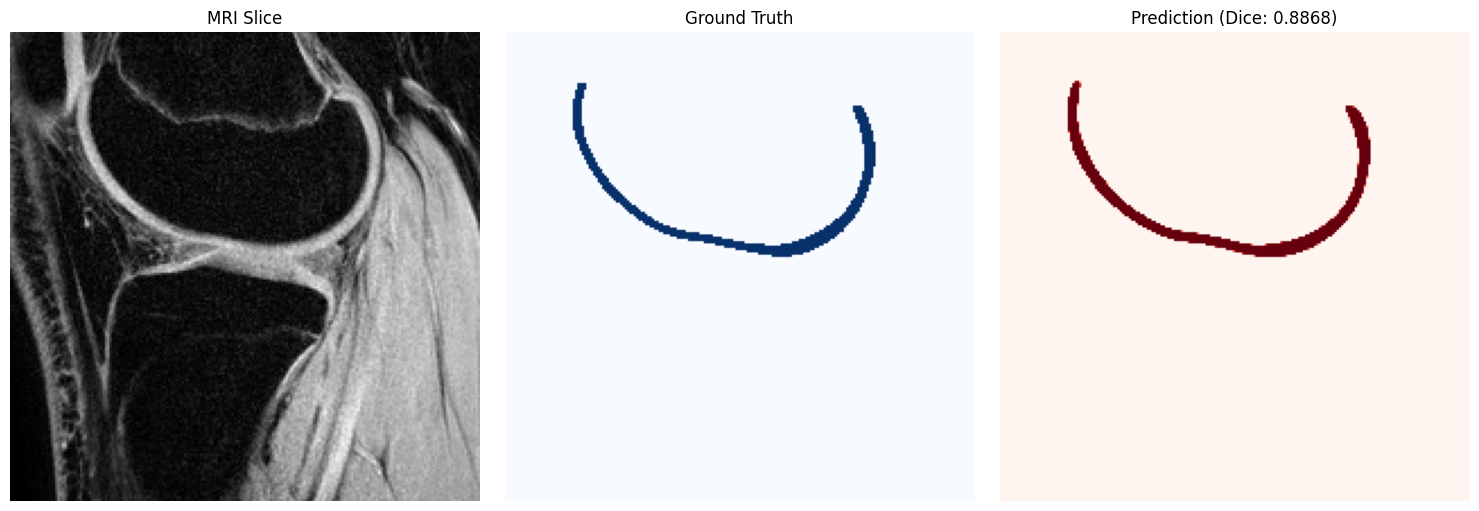

Evaluating:   1%|          | 1/172 [00:04<13:11,  4.63s/it]

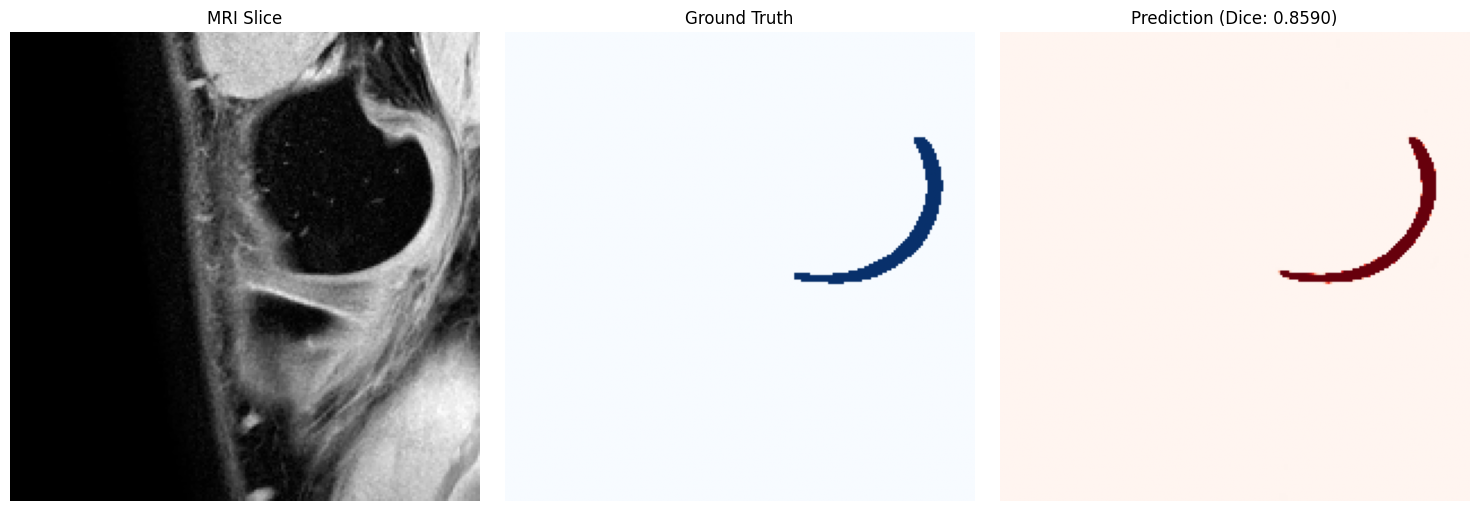

Evaluating:   1%|          | 2/172 [00:05<06:49,  2.41s/it]

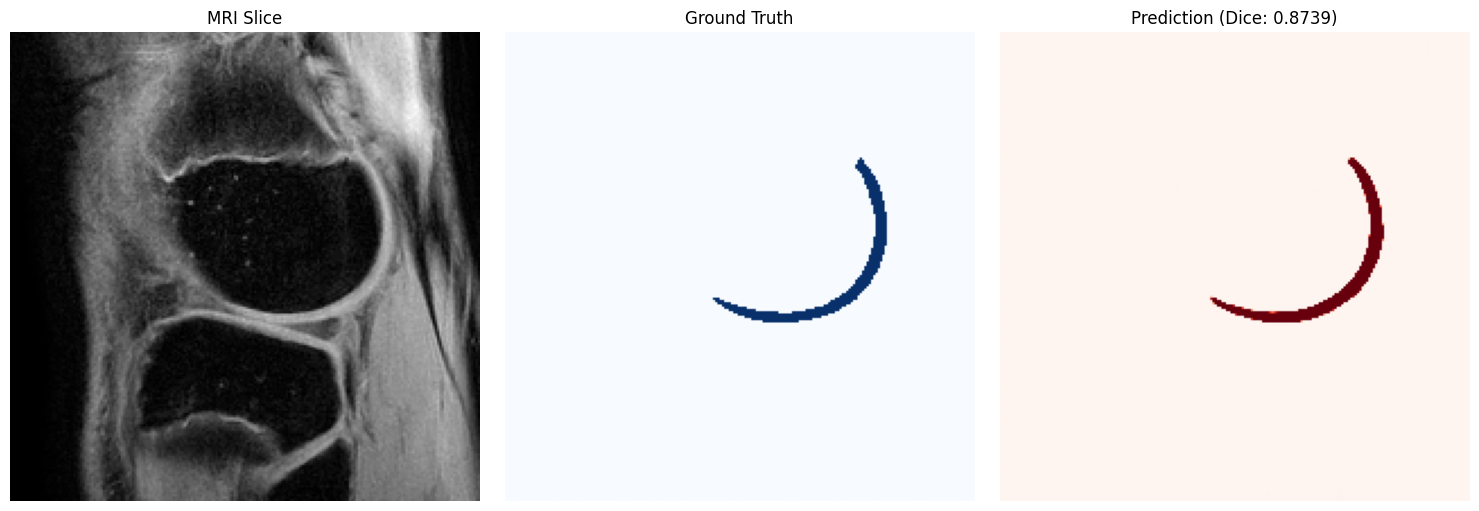

Evaluating:   2%|▏         | 3/172 [00:06<04:47,  1.70s/it]

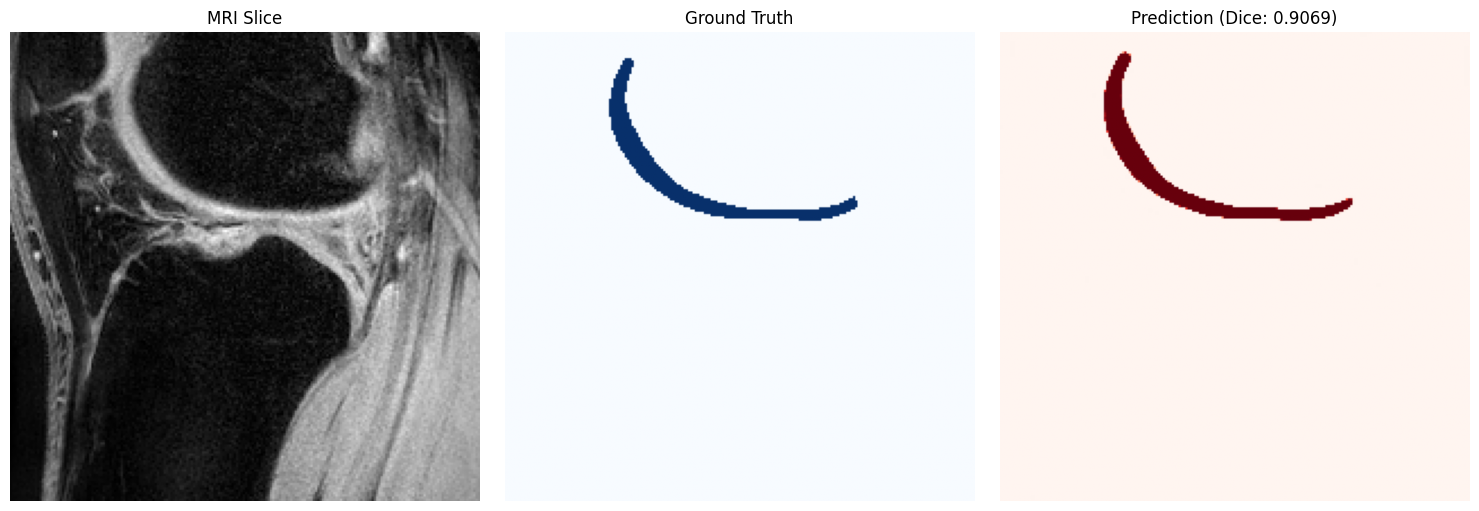

Evaluating:   3%|▎         | 5/172 [00:08<03:25,  1.23s/it]

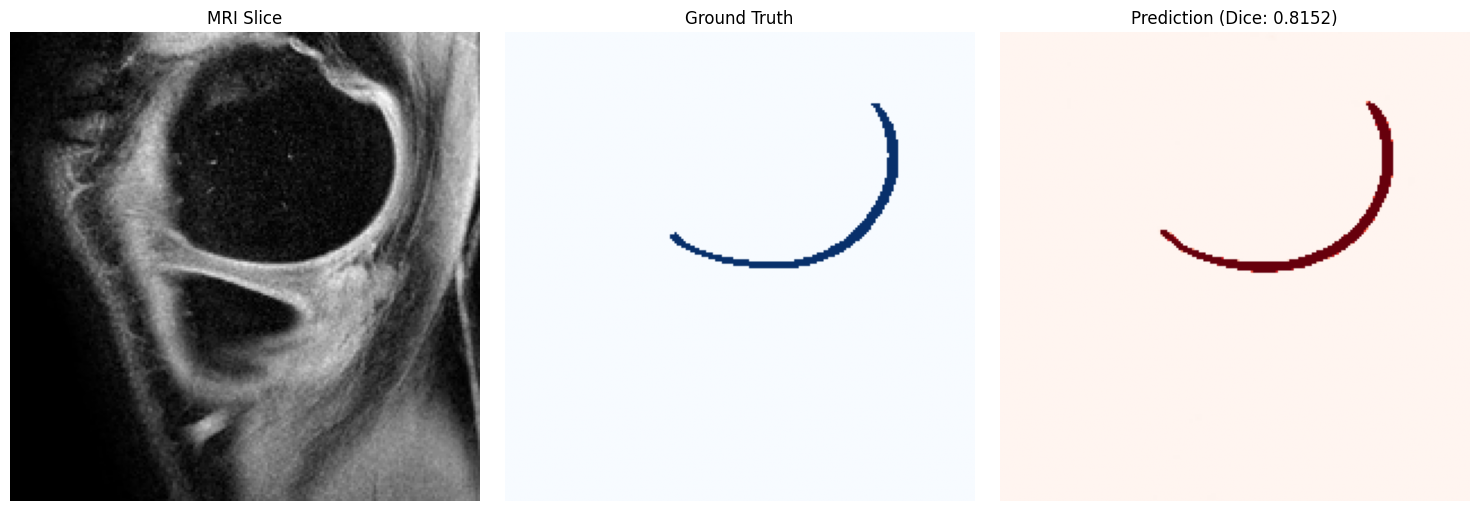

Evaluating:   3%|▎         | 6/172 [00:09<03:30,  1.27s/it]

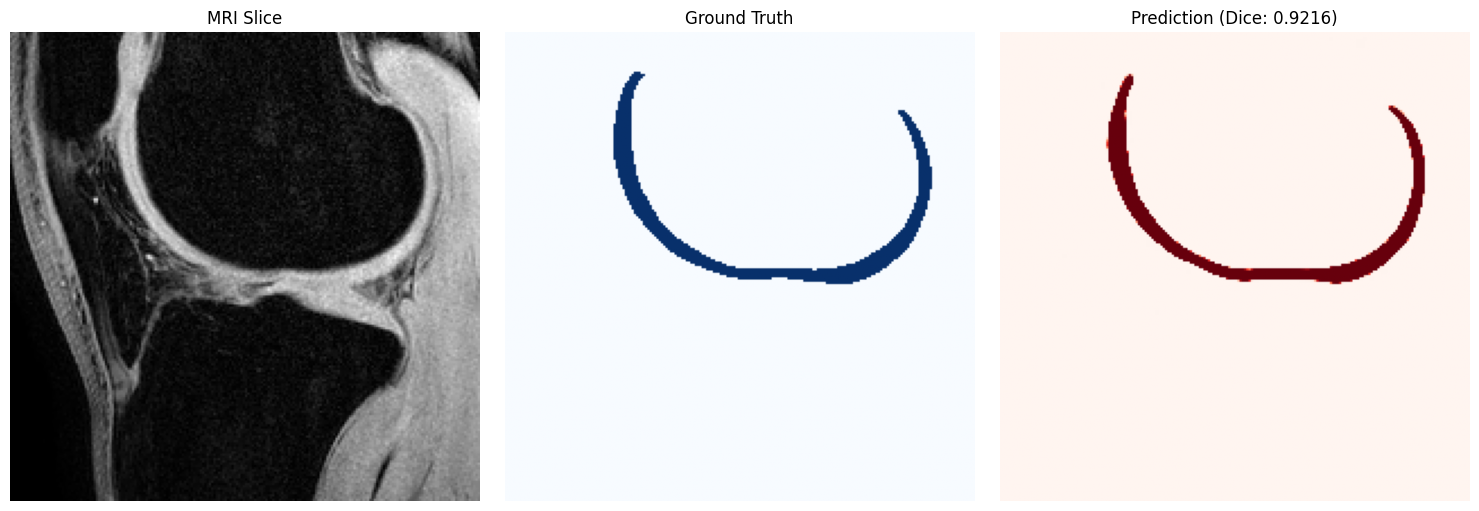

Evaluating:   4%|▍         | 7/172 [00:10<03:09,  1.15s/it]

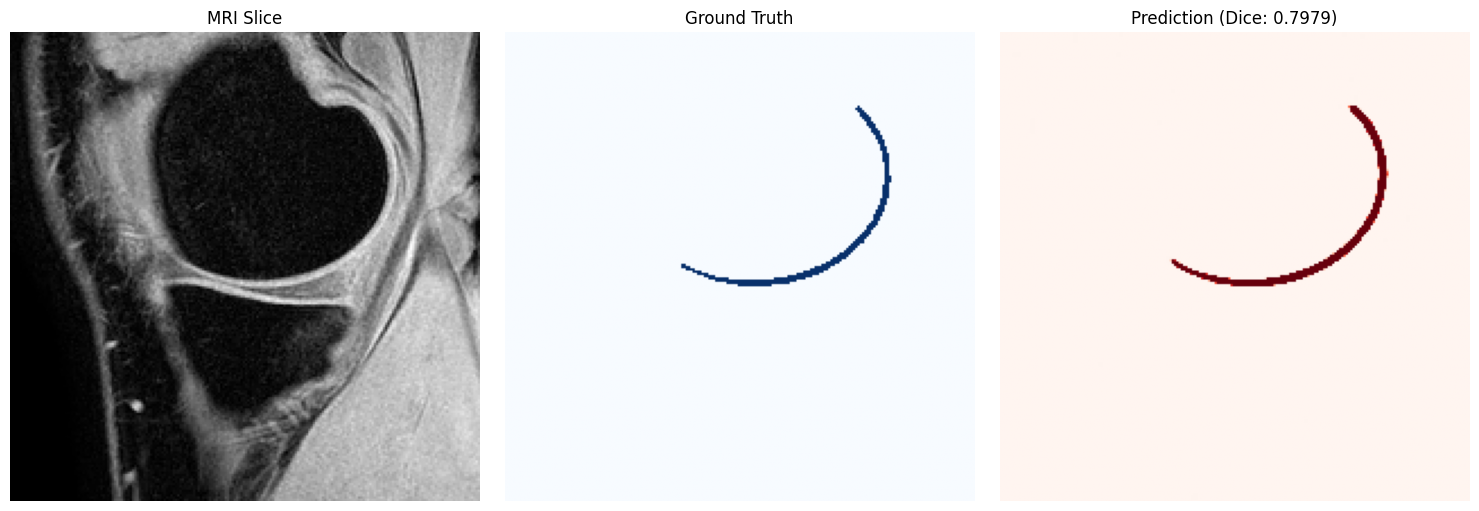

Evaluating:   5%|▍         | 8/172 [00:11<02:54,  1.06s/it]

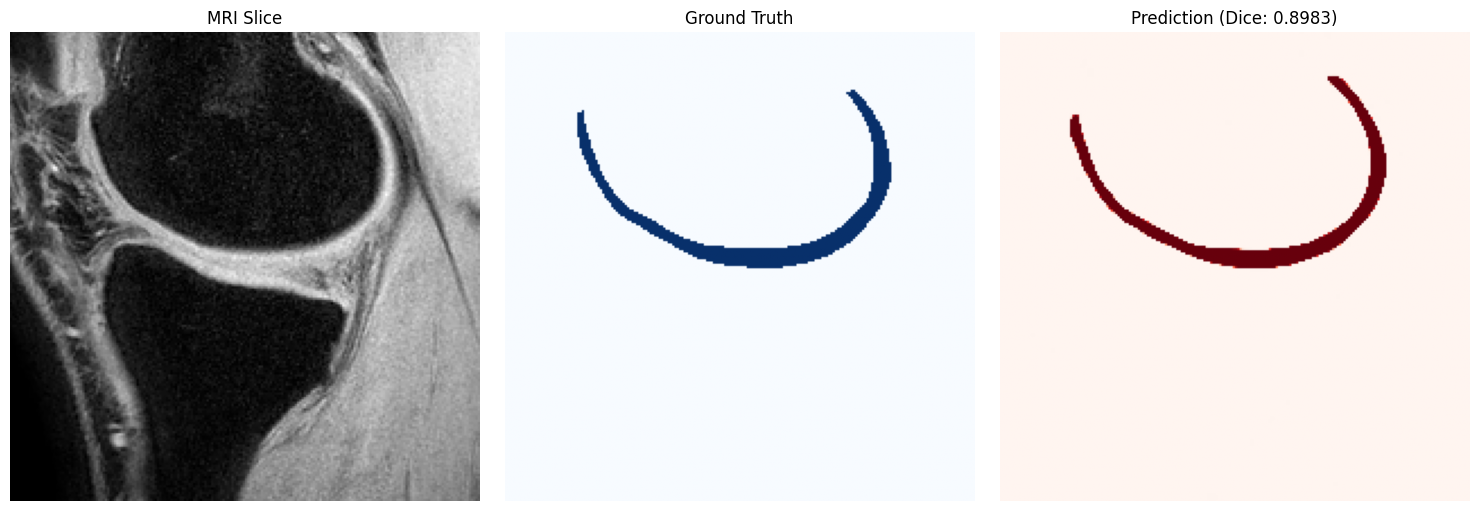

Evaluating:   5%|▌         | 9/172 [00:12<02:47,  1.03s/it]

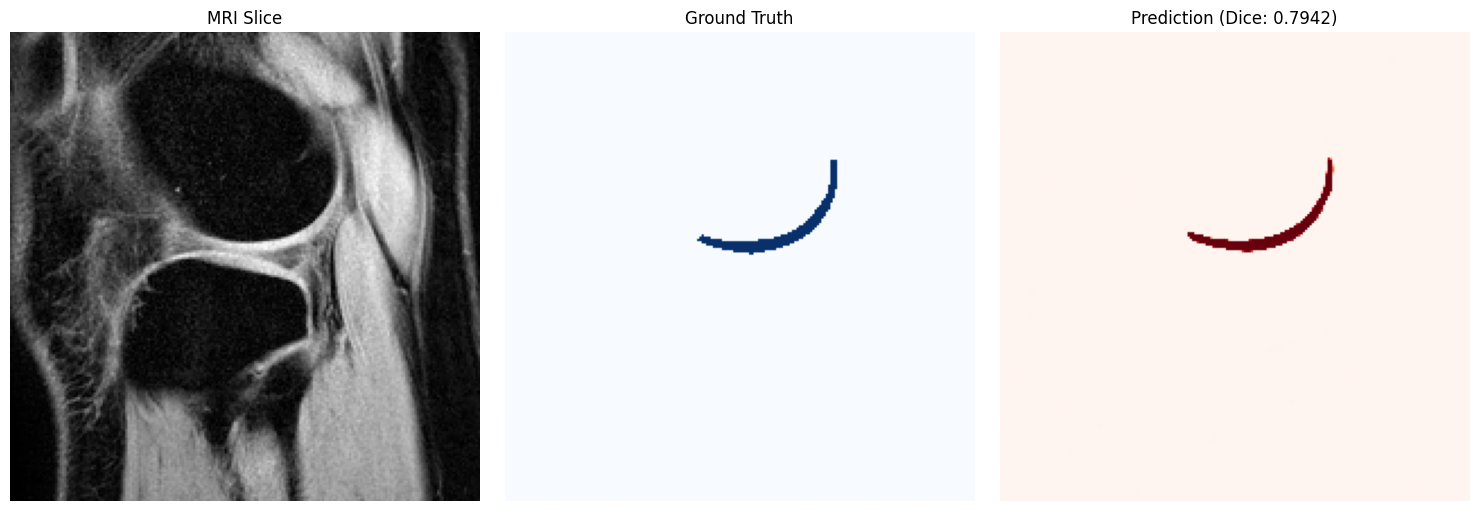

Evaluating:   6%|▌         | 10/172 [00:13<02:45,  1.02s/it]

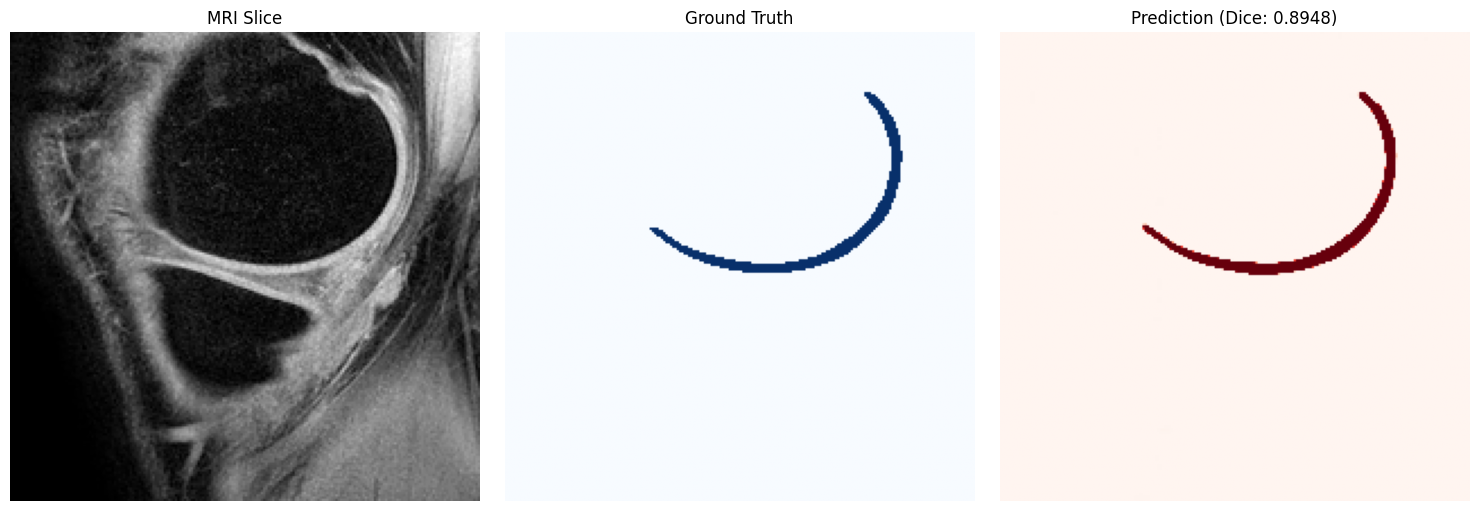

Evaluating: 100%|██████████| 172/172 [02:40<00:00,  1.07it/s]

Average Dice score: 0.8422


In [ ]:
# Evaluate femoral cartilage model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("\nEvaluating femoral cartilage model...")
femoral_model = UNet(in_channels=1, out_channels=1).to(device)
femoral_model.load_state_dict(torch.load('best_model_UNet.pth'))
avg_dice_femoral, dice_scores_femoral = evaluate_model_exclude(femoral_model, test_loader_femoral, device, True)

# Preprocessing Optimization
This section focuses on the application of a reinforcement learning agent to try and optimized the preprocessing via filtering of the images before they are passed to our previously trained Unet to improve model performance. The reward function was simply the average dice score of a fixed portion of the data without filtering/major preprocessing subtracted from the average dice of the same filtered images. Below is an image of the flow of information in this RL pipline.

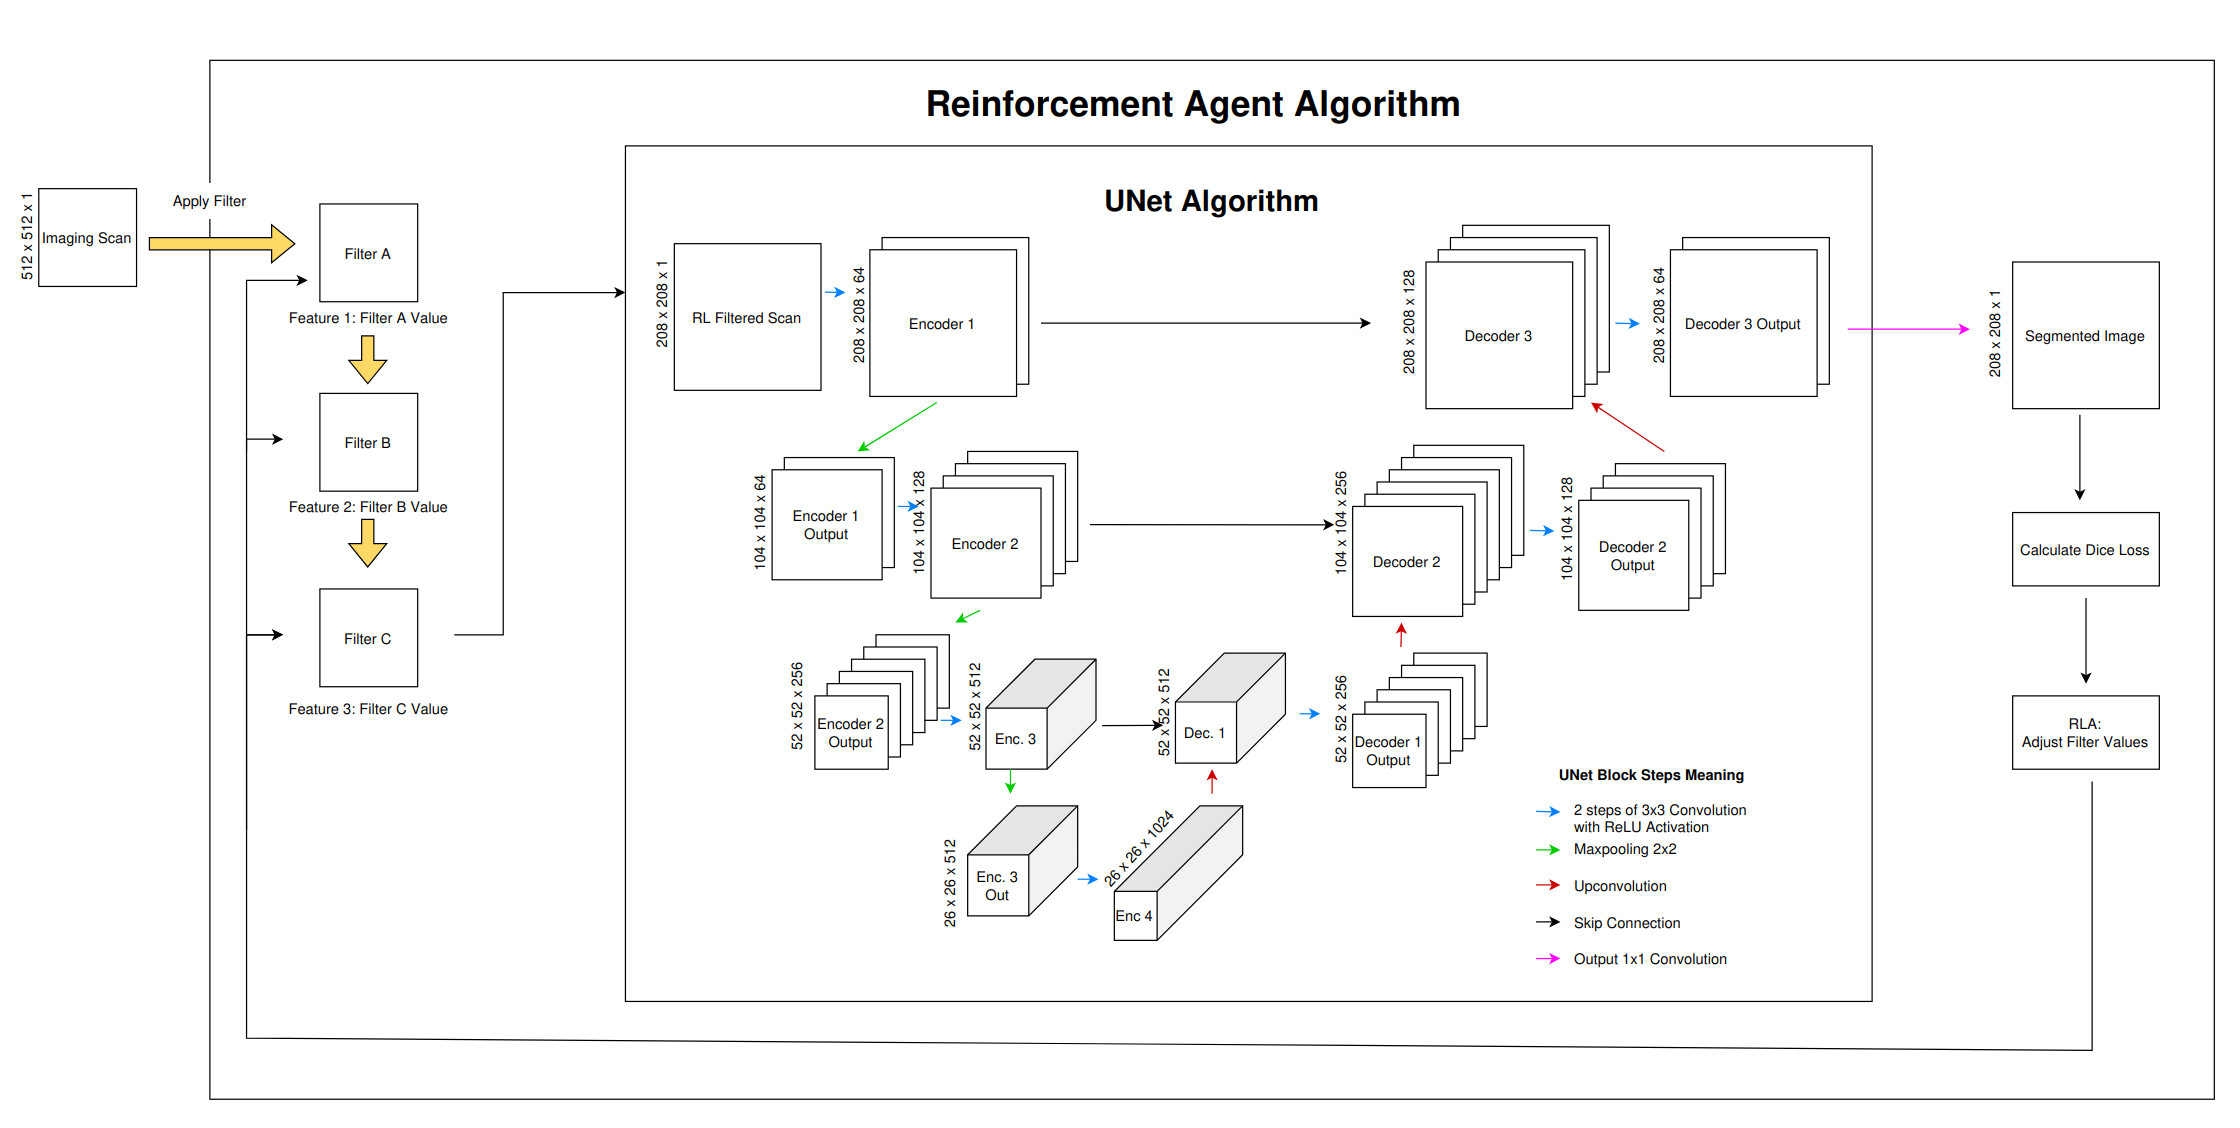

In [ ]:
from IPython.display import Image
Image('/content/drive/MyDrive/Final Project/UNet-RL_hybrid_model_cropped.jpg')

In [12]:
import gym
import numpy as np
import cv2
import torch
from gym import spaces
from torch.nn.functional import interpolate

class FilterOptimizationEnv(gym.Env):
    def __init__(self, model, test_loader, num_samples=40, device='cpu'):
        super(FilterOptimizationEnv, self).__init__()
        self.model = model.eval()
        self.test_loader = test_loader
        self.device = device
        self.num_samples = num_samples
        self.current_step = 0
        self.max_episode_steps = 1000
        print("Initialized Values")

        # Action space: [CLAHE clipLimit, Gaussian sigma, Laplacian weight]
        self.action_space = spaces.Box(low=np.array([0.1, 0.0, 0.0]),
                                       high=np.array([4.0, 2.0, 0.5]),
                                       dtype=np.float32)
        # Observation space: Filtered dice score
        self.observation_space = spaces.Box(low=0.0, high=1.0, dtype=np.float32)

        self.images, self.masks = self._collect_samples()

        self.base_dice = self._calculate_base_dice()

    def _collect_samples(self):
        images = []
        masks = []
        selected_samples = 0
        for batch in self.test_loader:
            if selected_samples >= self.num_samples:
                break
            if torch.all(batch["mask"] == 0):
              continue
            else:
              img, mask = batch["image"], batch["mask"]  # (B, 1, H, W)
              images.append(img.squeeze(0))
              masks.append(mask.squeeze(0))
              selected_samples += 1
        return images, masks

    def _calculate_base_dice(self):
        """
        Compute the dice of unprocessed images as a baseline for the reward function.
        """
        base_dice = []
        print("Computing Base Dice")
        for img, mask in zip(self.images, self.masks):
            img, mask = img.to(self.device), mask.to(self.device)
            with torch.no_grad():
                pred_orig = self.model(img.unsqueeze(0))
                base_dice.append(self.dice_score(pred_orig, mask))

        return np.mean(base_dice)

    def apply_filters(self, img_tensor, clahe_clip, gaussian_sigma, laplacian_weight):
        img_np = img_tensor.squeeze().cpu().numpy()  # (H, W), float32 in [0,1]
        img_uint8 = np.clip(img_np * 255, 0, 255).astype(np.uint8)

        # CLAHE
        clahe = cv2.createCLAHE(clipLimit=clahe_clip, tileGridSize=(8, 8))
        img_clahe = clahe.apply(img_uint8)

        # Gaussian
        ksize = int(gaussian_sigma * 4 + 1) | 1
        blurred = cv2.GaussianBlur(img_clahe, (ksize, ksize), sigmaX=gaussian_sigma)

        # Laplacian sharpening
        lap = cv2.Laplacian(blurred, cv2.CV_64F)
        sharpened = blurred.astype(np.float32) + laplacian_weight * lap
        sharpened = np.clip(sharpened, 0, 255)

        # Normalize back to [0, 1]
        out = (sharpened - sharpened.min()) / (sharpened.max() - sharpened.min())
        return torch.tensor(out, dtype=torch.float32).unsqueeze(0)  # (1, H, W)

    def dice_score(self, pred, target):
        """
        Dice loss for segmentation
        """
        smooth = 1.0

        # Flatten predictions and targets
        pred_flat = pred.view(-1)
        target_flat = target.view(-1)

        # Calculate intersection and union
        intersection = (pred_flat * target_flat).sum()
        union = pred_flat.sum() + target_flat.sum()

        # Calculate Dice coefficient
        dice = (2.0 * intersection + smooth) / (union + smooth)

        return dice.item()

    def step(self, action):
        self.current_step += 1
        clahe_clip, gaussian_sigma, laplacian_weight = action
        dice_filtered = []

        for img, mask in zip(self.images, self.masks):
            img, mask = img.to(self.device), mask.to(self.device)

            # Filtered image
            filtered = self.apply_filters(img, clahe_clip, gaussian_sigma, laplacian_weight).to(self.device)

            with torch.no_grad():
                pred_filt = self.model(filtered.unsqueeze(0))
                dice_filtered.append(self.dice_score(pred_filt, mask))

        avg_dice_filt = torch.mean(torch.tensor(dice_filtered)).item()
        reward = (avg_dice_filt - self.base_dice)

        done = self.current_step >= self.max_episode_steps

        return np.array([avg_dice_filt], dtype=np.float32), reward, done, {
            "avg_dice_orig": self.base_dice,
            "avg_dice_filt": avg_dice_filt
        }

    def reset(self):
        self.current_step = 0
        return self.action_space.sample()


    def render(self, mode='human'):
        pass


Recreate Data set if needed.

In [13]:
if os.path.exists('cartilage_dataset.csv'):
    print("Loading existing dataset...")
    df = pd.read_csv('cartilage_dataset.csv')
else:
    print("Preparing dataset...")
    df = prepare_dataset()

# Split dataset into train, validation, and test sets (70/20/10)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df[['has_femoral', 'has_tibial']])
val_df, test_df = train_test_split(temp_df, test_size=0.33, random_state=42, stratify=temp_df[['has_femoral', 'has_tibial']])

print(f"Train set: {len(train_df)} slices")
print(f"Validation set: {len(val_df)} slices")
print(f"Test set: {len(test_df)} slices")

# Create datasets for femoral cartilage
train_dataset_femoral = CartilageDataset(train_df, target_type='femoral')
val_dataset_femoral = CartilageDataset(val_df, target_type='femoral')
test_dataset_femoral = CartilageDataset(test_df, target_type='femoral')

# Create data loaders
batch_size = 32

train_loader_femoral = DataLoader(train_dataset_femoral, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader_femoral = DataLoader(val_dataset_femoral, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader_femoral = DataLoader(test_dataset_femoral, batch_size=1, shuffle=False, num_workers=4)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
femoral_model = UNet(in_channels=1, out_channels=1).to(device)
femoral_model.load_state_dict(torch.load('best_model_UNet.pth'))

Loading existing dataset...
Train set: 1209 slices
Validation set: 347 slices
Test set: 172 slices


<All keys matched successfully>

In [14]:
!pip install stable-baselines3[extra]
!pip install shimmy

In [15]:
from stable_baselines3 import PPO

env = FilterOptimizationEnv(femoral_model, test_loader_femoral, 40, device)

Initialized Values


/usr/local/lib/python3.11/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Computing Base Dice


In [ ]:
model = PPO("MlpPolicy", env, verbose=0)

best_reward = -np.inf
best_params = None

# Train in chunks so we can manually monitor rewards
total_steps = 10000
steps_per_eval = 1000

obs = env.reset()

for i in tqdm(range(0, total_steps, steps_per_eval), desc="Training Progress"):
    model.learn(total_timesteps=steps_per_eval, reset_num_timesteps=False, progress_bar=False)

    # Evaluate the model with current policy
    obs = env.reset()
    action, _ = model.predict(obs, deterministic=True)
    _, reward, _, _ = env.step(action)

    if reward > best_reward:
        best_reward = reward
        best_params = action.copy()

    print(f"Step {i + steps_per_eval}: Reward = {reward:.4f}, Best = {best_reward:.4f}, Action = {action}")

# Final summary
print("\nTraining complete.")
print(f"Best reward: {best_reward:.4f}")
print(f"Best filter parameters: {best_params}")


Initialized Values
Set Action and Observation
Made self.images and self.masks
Computing Base Dice


Training Progress:  10%|█         | 1/10 [07:55<1:11:19, 475.54s/it]

Step 1000: Reward = 0.0374, Best = 0.0374, Action = [0.1 0.  0. ]


Training Progress:  20%|██        | 2/10 [15:50<1:03:21, 475.24s/it]

Step 2000: Reward = 0.0374, Best = 0.0374, Action = [0.1 0.  0. ]


Training Progress:  30%|███       | 3/10 [23:46<55:28, 475.48s/it]  

Step 3000: Reward = 0.0374, Best = 0.0374, Action = [0.1 0.  0. ]


Training Progress:  40%|████      | 4/10 [31:41<47:32, 475.44s/it]

Step 4000: Reward = 0.0374, Best = 0.0374, Action = [0.1 0.  0. ]


Training Progress:  50%|█████     | 5/10 [39:36<39:36, 475.33s/it]

Step 5000: Reward = 0.0374, Best = 0.0374, Action = [0.1 0.  0. ]


Training Progress:  60%|██████    | 6/10 [47:31<31:40, 475.11s/it]

Step 6000: Reward = 0.0374, Best = 0.0374, Action = [0.1 0.  0. ]


Training Progress:  70%|███████   | 7/10 [55:25<23:44, 474.78s/it]

Step 7000: Reward = 0.0374, Best = 0.0374, Action = [0.1 0.  0. ]


Training Progress:  80%|████████  | 8/10 [1:03:21<15:49, 474.98s/it]

Step 8000: Reward = 0.0374, Best = 0.0374, Action = [0.1 0.  0. ]


Training Progress:  90%|█████████ | 9/10 [1:11:12<07:53, 473.76s/it]

Step 9000: Reward = 0.0374, Best = 0.0374, Action = [0.1 0.  0. ]


Training Progress: 100%|██████████| 10/10 [1:19:02<00:00, 474.30s/it]

Step 10000: Reward = 0.0374, Best = 0.0374, Action = [0.1 0.  0. ]

raining complete.
Best reward: 0.0374
Best filter parameters: [0.1 0.  0. ]


# Grid Search Validation
Initial intentions were to add more filter options to the RL agents search space but preliminary results indicated that the agent consistently converged to the minimum filter settings. To verify this result we performed a gridsearch of the low dimensional space we tested for the RL agent.

In [ ]:
import itertools

clahe_clip_vals = np.linspace(0.1, 4.0, 20)
gaussian_sigma_vals = np.linspace(0.0, 2.0, 20)
laplacian_weight_vals = np.linspace(0.0, 0.5, 20)

# Create grid of all parameter combinations
param_grid = list(itertools.product(clahe_clip_vals, gaussian_sigma_vals, laplacian_weight_vals))

# Create environment
env = FilterOptimizationEnv(femoral_model, test_loader_femoral, 40, device)

best_reward = -np.inf
best_params = None
all_rewards = []

print(f"Evaluating {len(param_grid)} total parameter combinations...")

for i, params in tqdm(enumerate(param_grid)):
    env.reset()
    _, reward, _, info = env.step(obs)
    all_rewards.append(reward)
    if reward > best_reward:
        best_reward = reward
        best_params = params
        print(f"{i+1}/{len(param_grid)} - Params: {params}, Reward: {reward:.4f}")

print("\nParameter sweep complete.")
print(f"Best reward: {best_reward:.4f}")
print(f"Best filter parameters: {best_params}")


Initialized Values
Set Action and Observation


/usr/local/lib/python3.11/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Made self.images and self.masks
Computing Base Dice
Evaluating 8000 total parameter combinations...


1it [00:00,  4.56it/s]

1/8000 - Params: (np.float64(0.1), np.float64(0.0), np.float64(0.0)), Reward: 0.0374


2it [00:00,  4.48it/s]

2/8000 - Params: (np.float64(0.1), np.float64(0.0), np.float64(0.02631578947368421)), Reward: 0.0383


8000it [30:19,  4.40it/s]


Parameter sweep complete.
Best reward: 0.0383
Best filter parameters: (np.float64(0.1), np.float64(0.0), np.float64(0.02631578947368421))


In [ ]:
all_rewards = np.array(all_rewards)
print(np.mean(all_rewards))
print(np.max(all_rewards))
print(np.min(all_rewards))
print(np.sum(all_rewards > 0))
for i in range(len(all_rewards)):
    if all_rewards[i] < 0:
        continue
    else:
        print(f"Params: {param_grid[i][0]}, {param_grid[i][1]}, {param_grid[i][2]}, Reward: {all_rewards[i]:.4f}")

-0.8522502050548796
0.03830653429031328
-4.097292602062225
96
Params: 0.1, 0.0, 0.0, Reward: 0.0374
Params: 0.1, 0.0, 0.02631578947368421, Reward: 0.0383
Params: 0.1, 0.0, 0.05263157894736842, Reward: 0.0334
Params: 0.1, 0.0, 0.07894736842105263, Reward: 0.0234
Params: 0.1, 0.0, 0.10526315789473684, Reward: 0.0093
Params: 0.1, 0.10526315789473684, 0.0, Reward: 0.0374
Params: 0.1, 0.10526315789473684, 0.02631578947368421, Reward: 0.0383
Params: 0.1, 0.10526315789473684, 0.05263157894736842, Reward: 0.0334
Params: 0.1, 0.10526315789473684, 0.07894736842105263, Reward: 0.0234
Params: 0.1, 0.10526315789473684, 0.10526315789473684, Reward: 0.0093
Params: 0.1, 0.21052631578947367, 0.0, Reward: 0.0374
Params: 0.1, 0.21052631578947367, 0.02631578947368421, Reward: 0.0383
Params: 0.1, 0.21052631578947367, 0.05263157894736842, Reward: 0.0334
Params: 0.1, 0.21052631578947367, 0.07894736842105263, Reward: 0.0234
Params: 0.1, 0.21052631578947367, 0.10526315789473684, Reward: 0.0093
Params: 0.1, 0.3

False


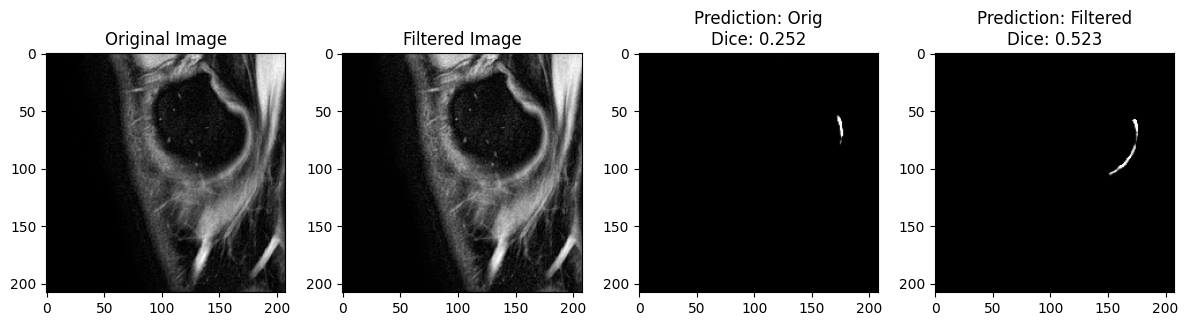

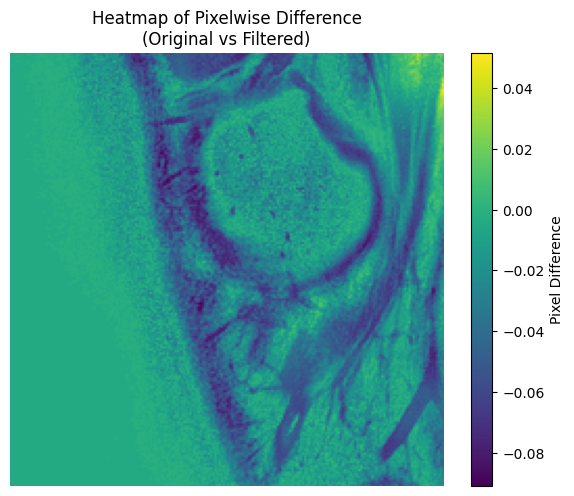

In [16]:
# Define filter parameters
clahe_clip = .1 #0.7157894736842105
gaussian_sigma = 0 #0.21052631578947367
laplacian_weight = 0 #0.02631578947368421

dice_diff = []
all_dice_orig = []
all_dice_filtered = []

for img_index in range(40):
  img = env.images[img_index].to(env.device)
  mask = env.masks[img_index].to(env.device)
  # Apply filters
  filtered = env.apply_filters(img, clahe_clip, gaussian_sigma, laplacian_weight).to(env.device)

  # Run both through the model
  with torch.no_grad():
      pred_orig = env.model(img.unsqueeze(0))         # shape: (1, 1, H, W)
      pred_filt = env.model(filtered.unsqueeze(0))    # shape: (1, 1, H, W)

  # Compute Dice scores
  dice_orig = env.dice_score(pred_orig, mask)
  dice_filt = env.dice_score(pred_filt, mask)
  all_dice_orig.append(dice_orig)
  all_dice_filtered.append(dice_filt)

  dice_diff.append(dice_filt - dice_orig)

dice_diff = np.array(dice_diff)

img = env.images[np.argmax(dice_diff)].to(env.device)
mask = env.masks[np.argmax(dice_diff)].to(env.device)

filtered = env.apply_filters(img, clahe_clip, gaussian_sigma, laplacian_weight)
print(torch.allclose(env.images[np.argmax(dice_diff)], filtered, atol=1e-6))

with torch.no_grad():
    pred_orig = env.model(env.images[np.argmax(dice_diff)].unsqueeze(0).to(env.device))
    pred_filt = env.model(env.masks[np.argmax(dice_diff)].unsqueeze(0).to(env.device))

# Plot sample result
plt.figure(figsize=(12, 6))

plt.subplot(1, 4, 1)
plt.imshow(img.squeeze().cpu(), cmap='gray')
plt.title("Original Image")

plt.subplot(1, 4, 2)
plt.imshow(filtered.squeeze().cpu(), cmap='gray')
plt.title("Filtered Image")

plt.subplot(1, 4, 3)
plt.imshow(pred_orig.squeeze().cpu(), cmap='gray')
plt.title(f"Prediction: Orig\nDice: {all_dice_orig[np.argmax(dice_diff)]:.3f}")

plt.subplot(1, 4, 4)
plt.imshow(pred_filt.squeeze().cpu(), cmap='gray')
plt.title(f"Prediction: Filtered\nDice: {all_dice_filtered[np.argmax(dice_diff)]:.3f}")

plt.tight_layout()
plt.show()

pixel_diff = img.squeeze().cpu() - filtered.squeeze().cpu()

# Plot the heatmap of differences
plt.figure(figsize=(6, 5))
plt.imshow(pixel_diff.squeeze().cpu(), cmap='viridis')
plt.colorbar(label='Pixel Difference')
plt.title("Heatmap of Pixelwise Difference\n(Original vs Filtered)")
plt.axis('off')
plt.tight_layout()
plt.show()


# Test Code
Used for verification and visualization of other aspects of the code above. Non functional and

(512, 512, 64, 4)
(208, 208)
[ 7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53]


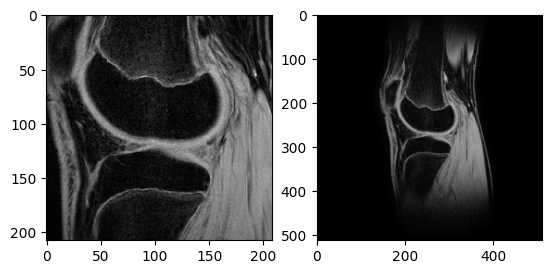

In [19]:
data = []

# Get all patient directories
patient_dirs = sorted([d for d in os.listdir('.') if os.path.isdir(d) and d.isdigit()])
#for patient_id in tqdm(patient_dirs, desc="Processing patients"):
    # Process left knee (series 401)
patient_id = '003'
left_mri_file = os.path.join(patient_id, f'T1rho_S401.mat')

left_mask_file = os.path.join(patient_id, f'T1rho_S401_prois.mat')

if os.path.exists(left_mri_file) and os.path.exists(left_mask_file):
    # Load MRI data to get number of slices
    try:
        mri_data = loadmat(left_mri_file)
        v = mri_data['v']
        slice_index = 20
        full_slice = np.squeeze(v[:,:,slice_index,0])
        print(v.shape)
        mri_slice = np.squeeze(v[152:360,152:360,slice_index,0])
        print(mri_slice.shape)
        num_slices = v.shape[2]

        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(mri_slice, cmap='gray')
        plt.subplot(1,2,2)
        plt.imshow(full_slice, cmap='gray')

        # Load mask data to get slices with masks
        mask_data = loadmat(left_mask_file)
        rsl = mask_data['rsl'].flatten() - 1  # Convert to 0-based indexing
        rslf = mask_data['rslf'].flatten() - 1 if 'rslf' in mask_data else np.array([])
        rslt = mask_data['rslt'].flatten() - 1 if 'rslt' in mask_data else np.array([])
        print(rslf)
        # Add all slices to dataset
        for slice_idx in range(num_slices):
            has_mask = slice_idx in rsl
            has_femoral = slice_idx in rslf
            has_tibial = slice_idx in rslt

            data.append({
                'patient_id': patient_id,
                'side': 'Left',
                'mri_file': left_mri_file,
                'mask_file': left_mask_file,
                'slice_idx': slice_idx,
                'has_mask': has_mask,
                'has_femoral': has_femoral,
                'has_tibial': has_tibial
            })
    except Exception as e:
        print(f"Error processing {left_mri_file}: {e}")
else:
  print("Shit")

In [ ]:
if os.path.exists('cartilage_dataset.csv'):
    print("Loading existing dataset...")
    df = pd.read_csv('cartilage_dataset.csv')
else:
    print("Preparing dataset...")
    df = prepare_dataset()

# Split dataset into train, validation, and test sets (80/10/10)
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df[['has_femoral', 'has_tibial']])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df[['has_femoral', 'has_tibial']])

print(f"Train set: {len(train_df)} slices")
print(f"Validation set: {len(val_df)} slices")
print(f"Test set: {len(test_df)} slices")

# Create datasets for femoral cartilage
train_dataset_femoral = CartilageDataset(train_df, target_type='femoral')
val_dataset_femoral = CartilageDataset(val_df, target_type='femoral')
test_dataset_femoral = CartilageDataset(test_df, target_type='femoral')

Loading existing dataset...
Train set: 1382 slices
Validation set: 173 slices
Test set: 173 slices


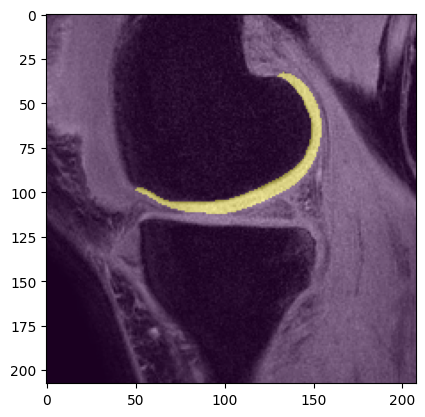

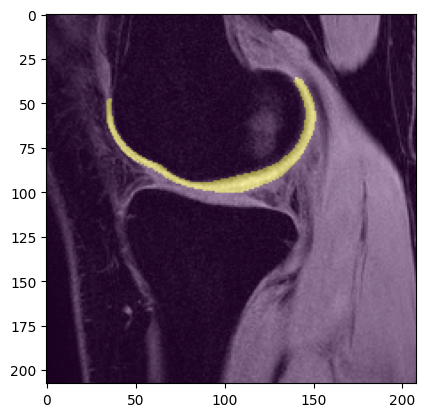

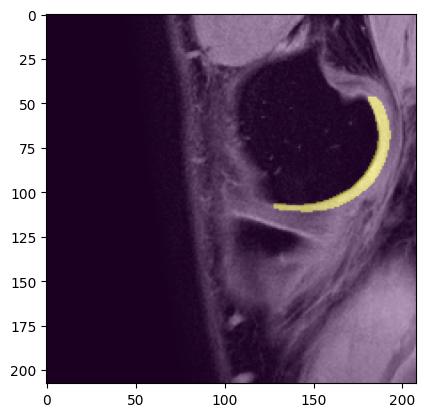

In [22]:
for i in np.random.choice(len(test_dataset_femoral), 3):
  plt.figure()
  plt.imshow(test_dataset_femoral[i]["image"][0, :, :], cmap='gray')
  plt.imshow(test_dataset_femoral[i]["mask"][0, :, :], alpha = 0.4)

In [ ]:
from stable_baselines3 import PPO
import pickle

env = FilterOptimizationEnv(femoral_model, test_loader_femoral, 25, device)

model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=1000, progress_bar=True)

obs = env.reset()
action, _ = model.predict(obs, deterministic=True)
print("Best parameters found:", action)

with open("best_filter_params.pkl", "wb") as f:
    pickle.dump(best_action, f)

